# CDS Par Spread Returns Construction

## Paper Introduction

This construction is based upon the structure proposed by Siriwardane, Sunderam, and Wallen in Segmented Arbitrage (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3960980). The original paper studies the concept of implied arbitrage returns in many different markets. If markets were truly frictionless, we would expect there to be perfect correlation between all of the arbitrage returns. This is because efficient capital allocation would dictate that capital be spent where the best opportunity is, thus dictating the arbitrage opportunites we calculate via different product would have correlating rates as capital would be allocated to a different source if the arbitrage opportunity looks more attractive.

## CDS Par Spread Returns

### Spread Construction

In the following notebook, we will walk through the steps to constructing the implied arbitrage found in the CDS and corporate bond market as specified in the Appendix of the paper (https://static1.squarespace.com/static/5e29e11bb83a3f5d75beb17d/t/654d74d916f20316049a0889/1699575002123/Appendix.pdf). The authors define the CDS basis ($CB$) as

$$
CB_{i, t, \tau} = CDS_{i, t, \tau} - FR_{i, t, \tau}
$$

where:
- $FR_{i, t, \tau}$ = time $t$ floating rate spread implied by a fixed-rate corporate bond issued by firm $i$ at tenor $\tau$
- $CDS_{i, t, \tau}$ = time $t$ Credit Default Swap (CDS) par spread for firm $i$ with tenor $\tau$

A negative basis implies an investor could earn a positive arbitrage profit by going long the bond and purchasing CDS protection. The investor would pay a lower par spread than the coupon of the bond itself and then receive value from the default. 

The value of $FR$ is substituted by the paper with **Z-spread** which we also modify in our construction. We will go into the substitution in detail later. 

The value of $CDS$ is interpolated by the authors using a cubic spline function.

### Implied Risk Free Return

Given the CDS spread from above, traditional construction of a risk free rate for implied arbitrage implied the following return.

$$
rfr^{CDS}_{i, t, \tau} = y_{t, \tau} - CB_{i , t, \tau}
$$

where:
- $y_{t, \tau}$ = maturity matched treasury yield at time $t$

The risk free rate then can be seen as the treasury yield in addition to the basis recieved when executing the CDS basis trade (investor benefits from negative basis).



In [49]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm

import ctypes
from scipy.interpolate import CubicSpline

from merge_bond_treasury_redcode import *
from merge_cds_bond import *
from process_final_product import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
DATA_DIR = "../../FS-project-files"

# Replace with below later
# DATA_DIR = config("DATA_DIR")


# Initial Pull and analysis
TREASURY_ISSUE_FILE_NAME = "issue_data.parquet"
TREASURY_MONTHLY_FILE_NAME = "monthly_ts_data.parquet"
CORPORATES_MONTHLY_FILE_NAME = "wrds_bond.parquet"
RED_CODE_FILE_NAME = "RED_and_ISIN_mapping.parquet"

# Secondary Pull and final analysis
BOND_RED_CODE_FILE_NAME = "merged_bond_treas_red.pkl"
# BOND_RED_CODE_FILE_NAME = "merged_bond_treas_red.parquet"
CDS_FILE_NAME = "cds_final.pkl"
# CDS_FILE_NAME = "cds_final.parquet"
FINAL_ANALYSIS_FILE_NAME = "final_data.pkl"
# FINAL_ANALYSIS_FILE_NAME = "final_data.parquet"


### Step 1: Data Pull Part 1 (WRDS bond returns, Markit Redcode Mappings, WRDS Historical Treasuries)

First we pull corporate bond time series data (WRDS bond returns), treasury time series data, and some mapping features. 

The corporate bond time series data will be used to generate the FR value (calculated as the Z-spread of the corporate bonds). Treasury time series will also be used for this purpose as well as to generate treasury yields.

### Z-Spread of a Corporate Bond

The **Z-spread** (zero-volatility spread) of a corporate bond is the constant spread that must be added to the **zero-coupon Treasury yield curve** to make the **present value of the bond's cash flows equal to its market price**. 

### **Formula**
The Z-spread is found by solving the equation:

$$
P = \sum_{t=1}^{N} \frac{C_t}{(1 + r_t + Z)^t}
$$

where:
- $P$ = Market price of the bond  
- $C_t$ = Cash flow (coupon or principal) at time $t$  
- $r_t$ = Discount rate of the zero-coupon Treasury bond at time $t$  
- $Z$ = Z-spread  
- $N$ = Number of periods  

### Our construction Z-Spread Surrogate

The **Z-spread** accounts for different discount rates of a treasury. For our surrogate **Z-spread** ($z$) and in turn what we will be using to calculate **FR** will be the below representation.

$$
P = \sum_{t=1}^{N} \frac{C_t}{(1 + y_m + z)^t}
$$

where:
- $P$ = Market price of the bond  
- $C_t$ = Cash flow (coupon or principal) at time \( t \)  
- $y_m$ = Yield of the zero-coupon Treasury bond at time $t_m$
    - This is different because the yield is calculated at the time the market price is set is a fixed rate substitute for a varying discount rate
- $z$ = Z-spread surrogate
- $N$ = Number of periods 




### Step 1.1: Treasury merge

Since this step does not take very long, we will try it out. Since the treasury timeseries dataframe does not have maturity dates, we need to use issue information to track those down. Below is our processing:

In [51]:
treasury_monthly_data = pd.read_parquet(f"{DATA_DIR}/{TREASURY_MONTHLY_FILE_NAME}")
treasury_issue_data = pd.read_parquet(f"{DATA_DIR}/{TREASURY_ISSUE_FILE_NAME}")

In [52]:
treasury_monthly_data.head()

,kycrspid,kytreasno,mcaldt,tmpubout,tmyld
0,19610622.800000,200001.0,1960-10-31,NaN,0.000076
1,19610622.800000,200001.0,1960-11-30,NaN,0.000079
2,19610622.800000,200001.0,1960-12-30,NaN,0.000067
3,19610622.800000,200001.0,1961-01-31,NaN,0.000068
4,19610622.800000,200001.0,1961-02-28,NaN,0.000074


In [53]:
treasury_issue_data.head()

,kycrspid,kytreasno,tmatdt
0,19610622.800000,200001.0,1961-06-22
1,19610623.400000,200002.0,1961-06-23
2,19610629.400000,200003.0,1961-06-29
3,19610706.400000,200004.0,1961-07-06
4,19610713.400000,200005.0,1961-07-13


In [54]:
treasury_data_combined = generate_treasury_data(treasury_issue_data, treasury_monthly_data)

In [55]:
treasury_data_combined.head()

,kycrspid,kytreasno,mcaldt,tmpubout,tmatdt,treas_yld
0,19610622.800000,200001.0,1960-10-31,NaN,1961-06-22,0.028055
1,19610622.800000,200001.0,1960-11-30,NaN,1961-06-22,0.029241
2,19610622.800000,200001.0,1960-12-30,NaN,1961-06-22,0.024777
3,19610622.800000,200001.0,1961-01-31,NaN,1961-06-22,0.025169
4,19610622.800000,200001.0,1961-02-28,NaN,1961-06-22,0.027243


# Step 1.2 and 1.3: Merging treasury and bond time series, adding redcode mapping

## Step 1.2

Step 1.2 is relatively time intensive so we will not do it here. The code for it is in **merge_bond_treasury_redcode.py** in the function **merge_treasuries_into_bonds**. The more specific inputs are within the function itself.

The basic steps of the process are merging treasuries onto the corporate bonds using the start of the month data and the maturity dates. Given some mismatches of the end of month date, we use the year-month pair to match the report dates. The maturity dates usually do not match up relatively well. However, given how the treasuries are usually long term, we merge based upon a "day-window," where we grab treasury data from maturities within the day-window of the corporate bond's maturity and then choose the treasury with the highest public outstanding value. With higher amounts in the public, we can assume there is generally more liquidity and the priced treasury yield is more accurate. However, given the scarcity of the public outstanding data, we will choose the first treasury in the dataframe if there is no public outstanding data.

## Step 1.3

Step 1.3 is simpled compared to 1.2. However, since there is no convenient displayable product for step 1.2, we will touch on the steps of 1.3 and display the outputs. The code for it is in **merge_bond_treasury_redcode.py** in the function **merge_redcode_into_bond_treas**. The more specific inputs are within the function itself.

Given CDS tables record issuers of the Credit Default Swaps using Redcode and the bond tables only had CUSIPs, we needed to merge a redcode-CUSIP matching table to the end product of step 1.2 for CDS merging later on.

We will pull the results without processing for CDS implied arbitrage returns.

In [56]:
bond_redcode_merged_data = pd.read_pickle(f"{DATA_DIR}/{BOND_RED_CODE_FILE_NAME}")

In [57]:
bond_redcode_merged_data.head()

,cusip,company_symbol,date,maturity,amount_outstanding,yield,rating,price_eom,t_spread,treas_yld,issuer_cusip,redcode
0,001957AM1,T,2002-07-31,2004-04-01,400000.0,0.085600,1,97.213129,0.014847,0.020340,001957,001AEC
1,001957AM1,T,2002-07-31,2004-04-01,400000.0,0.085600,1,97.213129,0.014847,0.020340,001957,0A226X
2,001957AM1,T,2002-08-31,2004-04-01,400000.0,0.062781,1,100.684813,0.011224,0.019416,001957,001AEC
3,001957AM1,T,2002-08-31,2004-04-01,400000.0,0.062781,1,100.684813,0.011224,0.019416,001957,0A226X
4,001957AM1,T,2002-09-30,2004-04-01,400000.0,0.066960,1,100.066504,0.007308,0.015797,001957,001AEC


# Step 2: CDS data pull and CDS data processing

## Step 2.1: CDS data pull

The CDS data pull will be filtered using the redcodes from the above **bond_redcode_merged_data** dataframe, ensuring that only the firms that have corporate bond data are pulled from the CDS table. This data from Markit is daily.

## Step 2.2: CDS data processing

Let's first observe the data to see what we are working with:


In [58]:
cds_data = pd.read_pickle(f"{DATA_DIR}/{CDS_FILE_NAME}")

In [59]:
cds_data.head()

,date,ticker,redcode,parspread,tenor,tier,country,year
0,2002-01-01,T,001AEC,0.017589,10Y,SNRFOR,United States,2002
1,2002-01-01,T,001AEC,0.016295,10Y,SNRFOR,United States,2002
2,2002-01-01,T,001AEC,0.015566,10Y,SNRFOR,United States,2002
3,2002-01-01,T,001AEC,0.013413,1Y,SNRFOR,United States,2002
4,2002-01-01,T,001AEC,0.012417,1Y,SNRFOR,United States,2002


The CDS data has a flaw: the **tenor** is displayed as opposed to **maturity date** which would allow for more accurate cubic splines of the par spread. To approximate the correct number of days, we use tenor as is and annualize. 

For example, if the tenor is $3Y$, the number of days that we use to annualize is $3 \times 365 = 1095$. 

In our processing function **merge_cds_into_bonds**, we grab the **redcode, date** tuples for which we can generate a good cubic spline function, filter the bond and treasury dataframe (output of step 1). 

Then, we use the days between the **maturity** and the **date** for each corporate bond as the input for the cubic spline function for par spread generation. Thus, we end up with the final dataframe with bond, treasury, and cds data all merged together.

In [60]:
final_data = merge_cds_into_bonds(bond_redcode_merged_data, cds_data)

c:\Users\xuv14\Winter 2025 FINM\Full Stack\full_stack_project\src\merge_cds_bond.py:138: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  par_df = par_df.applymap(safe_convert)


In [61]:
final_data.head()

,cusip,date,maturity,yield,rating,treas_yld,par_spread,t_spread,price_eom,amount_outstanding
0,001957AM1,2002-07-31,2004-04-01,0.085600,1,0.020340,0.069154,0.014847,97.213129,400000.0
4,001957AM1,2002-09-30,2004-04-01,0.066960,1,0.015797,0.046843,0.007308,100.066504,400000.0
6,001957AM1,2002-10-31,2004-04-01,0.066670,0,0.014777,0.039719,0.007682,100.112053,400000.0
10,001957AM1,2002-12-31,2004-04-01,0.036044,0,0.012791,0.022669,0.010935,103.810897,123856.0
12,001957AM1,2003-01-31,2004-04-01,0.036545,0,0.013383,0.024194,0.010090,103.500000,123856.0


# Step 3: Processing

Given our explanations from before, here is our construction of the $FR$ factor. The $CB$ and $rf$ are constructed as specified in the paper given our custom $FR$.

$$
FR_{i, t, \tau} = cy_{i, t, \tau} - y_{t, \tau}
$$
where:
- $cy_{i, t, \tau}$ = time $t$ corporate bond yield for firm $i$ with tenor $\tau$
- $y_{t, \tau}$ = time $t$ yield of treasury with tenor $\tau$

We threw out some unreasonable data for the rf values exceeding 1 (risk free annual return of 100%). 

In [62]:
processed_final_data = calc_cb_spread(final_data)

In [63]:
processed_final_data.head()

,cusip,date,maturity,yield,rating,treas_yld,par_spread,t_spread,price_eom,amount_outstanding,FR,CB,rfr
0,001957AM1,2002-07-31,2004-04-01,0.085600,1,0.020340,0.069154,0.014847,97.213129,400000.0,0.065259,0.003894,0.016446
4,001957AM1,2002-09-30,2004-04-01,0.066960,1,0.015797,0.046843,0.007308,100.066504,400000.0,0.051163,-0.004320,0.020116
6,001957AM1,2002-10-31,2004-04-01,0.066670,0,0.014777,0.039719,0.007682,100.112053,400000.0,0.051893,-0.012173,0.026950
10,001957AM1,2002-12-31,2004-04-01,0.036044,0,0.012791,0.022669,0.010935,103.810897,123856.0,0.023253,-0.000584,0.013376
12,001957AM1,2003-01-31,2004-04-01,0.036545,0,0.013383,0.024194,0.010090,103.500000,123856.0,0.023163,0.001031,0.012351


# Step 4: Results

## Risk free rates

As we can see below, the risk free rates all seem to be relatively reasonable. Generally, we see that the risk free return implied by this arbitrage structure favored high yield bonds in many periods. This could potentially be due to higher than normal discounting for the high yield corporate bonds, hence the name high yield. The CDS par spreads demanded for these HY bonds could not be compensating for this higher yield. 

c:\Users\xuv14\Winter 2025 FINM\Full Stack\full_stack_project\src\process_final_product.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Plot saved to ../_output\rfr_plot.png


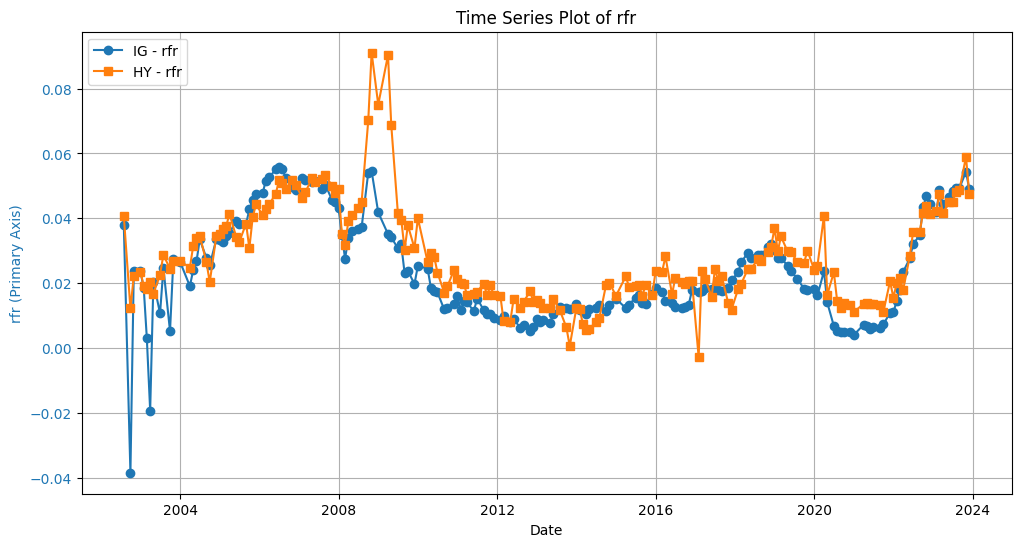

In [71]:
generate_graph(processed_final_data)

## Corporate Yield

We can see an obvious segmentation here. This is to be expected as high yield bonds are generally discounted more due to credit risk. This graph does explain some of the slight segmentation in risk free rates we see in the above graph.

c:\Users\xuv14\Winter 2025 FINM\Full Stack\full_stack_project\src\process_final_product.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Plot saved to ../_output\yield_plot.png


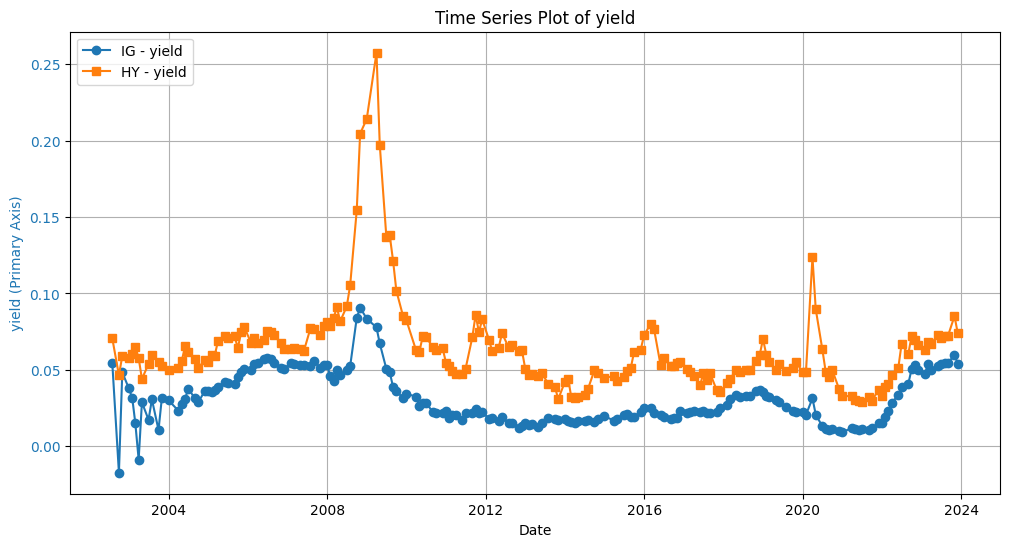

In [65]:
generate_graph(processed_final_data, 'yield')

## CDS Par Spread

It is expected that CDS par spread is relatively close to 0 for IG bonds. Interestingly, the HY bond CDS par spread matches relatively well with the spikes of the corporate yield. 

A quick observation of the time periods reveals these spikes occur around 2008 and 2020, in line with periods of recession. More firms would be defaulting and required yield for bonds to trade would be at an all time high, explaining movement in the CDS par spread and the corporate bond yields. 

c:\Users\xuv14\Winter 2025 FINM\Full Stack\full_stack_project\src\process_final_product.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Plot saved to ../_output\par_spread_plot.png


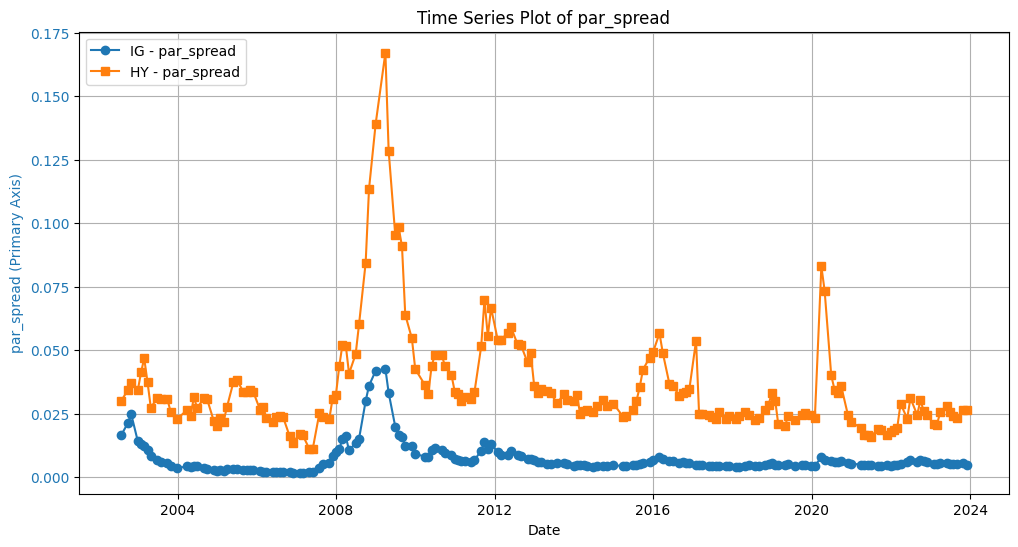

In [66]:
generate_graph(processed_final_data, 'par_spread')

In [67]:
processed_final_data.columns

Index(['cusip', 'date', 'maturity', 'yield', 'rating', 'treas_yld',
       'par_spread', 't_spread', 'price_eom', 'amount_outstanding', 'FR', 'CB',
       'rfr'],
      dtype='object')

## Investigation of Relative Corporate Bond Liquidity

### Spread ratio

Even in periods of high corporate yields, we see that corporate bonds still do not exceed 4 bps of bid-ask spread. Perhaps the existence of CDS protection maintains the bid price close to the ask. Interestingly, we do see occasional concurrent spikes in treasury yields and spread ratio. These 2 values are usually indicators of recessions. The concurrent spikes are probably results of a similar phenomenon. It is usually not necessary to look at a leading, lagging analysis of this time series.

### Amount Outstanding

Due to inflation and general growth of financial markets, amount outstanding growth is not wholly representative of the liquidity of the bonds. 

In [68]:
# spread percent, liquidity measure, in bps space
processed_final_data['spread bps'] = 10000 * processed_final_data['t_spread'] / processed_final_data['price_eom']

C:\Users\xuv14\AppData\Local\Temp\ipykernel_19772\817267633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_final_data['spread bps'] = 10000 * processed_final_data['t_spread'] / processed_final_data['price_eom']


c:\Users\xuv14\Winter 2025 FINM\Full Stack\full_stack_project\src\process_final_product.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Plot saved to ../_output\yield_spread bps_plot.png


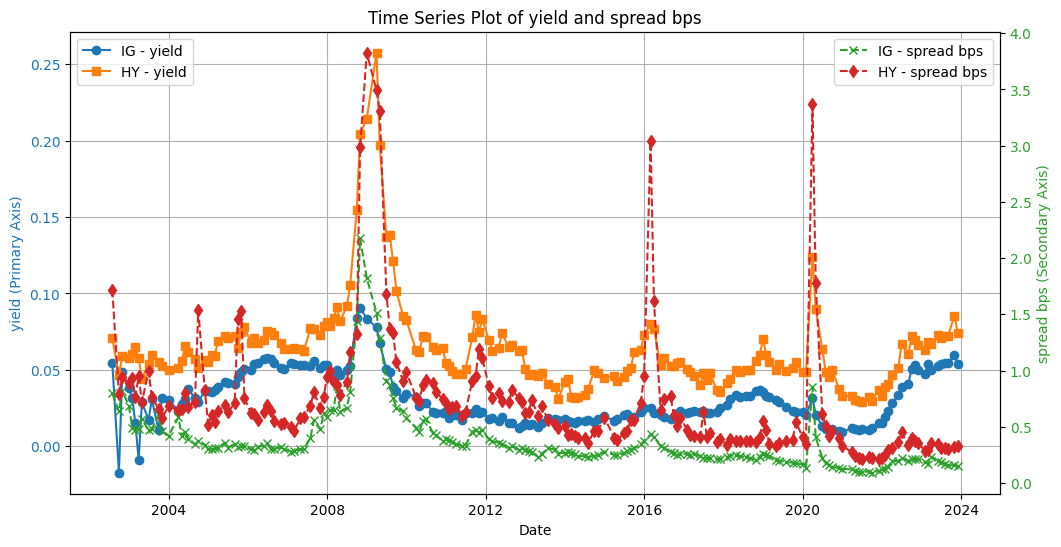

In [69]:
generate_graph(processed_final_data, col='yield', col2='spread bps', two=True)

c:\Users\xuv14\Winter 2025 FINM\Full Stack\full_stack_project\src\process_final_product.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Plot saved to ../_output\yield_amount_outstanding_plot.png


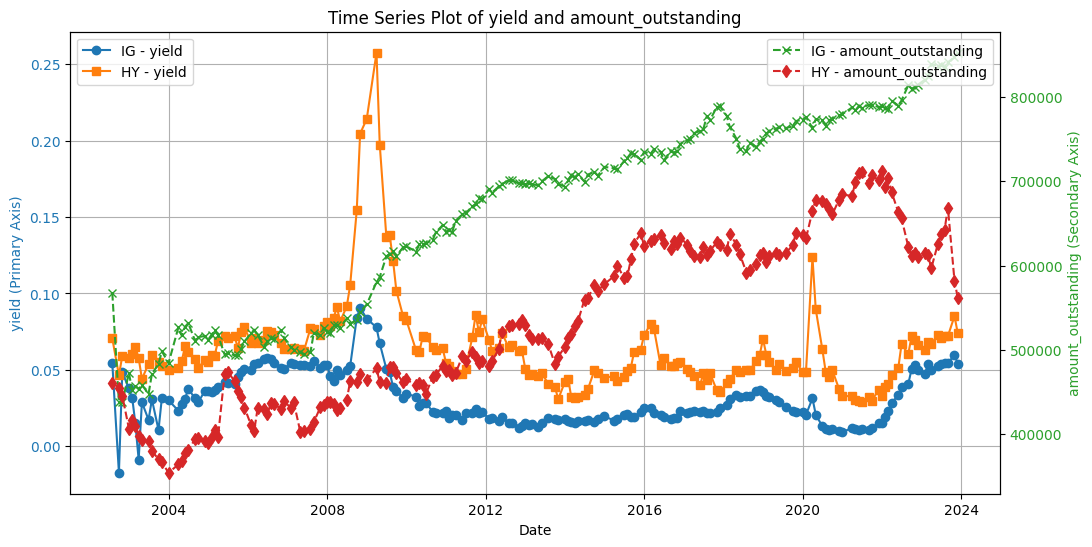

In [70]:
generate_graph(processed_final_data, col='yield', col2='amount_outstanding', two=True)